https://www.depends-on-the-definition.com/guide-sequence-tagging-neural-networks-python/

## Preprocessing

`words: [The, stock, rises, for, NASDAQ:SBUX, and, NASDAQ:MSFT]`

`is_ticker: [0, 0, 0, 0, 1, 0, 1]`

`dynamics: [O, O, O, O, <KEEP>, O, <BUY>]`

In [30]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving tag2ind.pkl to tag2ind.pkl
Saving tags.pkl to tags.pkl
Saving word2ind.pkl to word2ind.pkl
Saving words.pkl to words.pkl
Saving X_test.pkl to X_test.pkl
Saving X_train.pkl to X_train.pkl
Saving y_test.pkl to y_test.pkl
Saving y_train.pkl to y_train.pkl
User uploaded file "tag2ind.pkl" with length 62 bytes
User uploaded file "tags.pkl" with length 54 bytes
User uploaded file "word2ind.pkl" with length 1285161 bytes
User uploaded file "words.pkl" with length 1090564 bytes
User uploaded file "X_test.pkl" with length 5836962 bytes
User uploaded file "X_train.pkl" with length 13616162 bytes
User uploaded file "y_test.pkl" with length 23347364 bytes
User uploaded file "y_train.pkl" with length 54464164 bytes


In [1]:
!pip install gensim

    100% |████████████████████████████████| 23.6MB 1.7MB/s 
    100% |████████████████████████████████| 1.4MB 13.3MB/s 
    100% |████████████████████████████████| 133kB 18.8MB/s 
    100% |████████████████████████████████| 61kB 23.1MB/s 
    100% |████████████████████████████████| 4.8MB 6.9MB/s 
    100% |████████████████████████████████| 552kB 17.5MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


In [0]:
import pickle
from tqdm import tqdm
import numpy as np

import nltk
from nltk.stem import WordNetLemmatizer

In [4]:
data = pickle.load(open('data.pkl', 'rb'))

nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
def generate_article():
    
    for i in range(len(data['articles'])):
    
        text = data['articles'][i]
        tickers = [ticker.split(':')[-1] for ticker in data['tickers'][i]]
        targets = data['targets'][i]

        words = []
        is_ticker = []
        dynamics = []

        for word in nltk.word_tokenize(text):
            
            if word in tickers:
                is_ticker.append(True)
                ticker_index = tickers.index(word)
                dynamics.append(targets[ticker_index])
            else:
                word = word.lower()
                word = lemmatizer.lemmatize(word)

                is_ticker.append(False)
                dynamics.append('O')
                
            words.append(word)

        assert len(words) == len(is_ticker) == len(dynamics)
    
        yield words, is_ticker, dynamics

In [6]:
articles = [article for article in tqdm(generate_article())]

6079it [00:34, 177.28it/s]


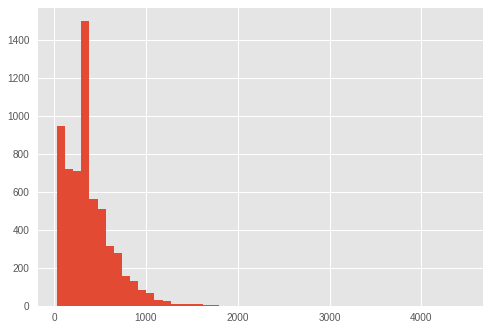

In [7]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

plt.hist([len(a[0]) for a in articles], bins=50)
plt.show()

## Data preparation

In [0]:
words = list(set([article_word for article in articles for article_word in article[0]]))
words += ['<pad>']
tags = list(set([article_dyn for article in articles for article_dyn in article[2]]))

max_len = 800
word2ind = {w : i for i, w in enumerate(words)}
tag2ind = {t : i for i, t in enumerate(tags)}
n_classes = len(tag2ind)

In [9]:
tag2ind

{'<BUY>': 0, '<KEEP>': 1, '<SELL>': 3, 'O': 2}

In [10]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [11]:
known_count = 0
embeddings = np.zeros((len(words), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 39469 out of 64951 word embeddings


In [0]:
from keras.preprocessing.sequence import pad_sequences

X = [[word2ind[article_word] for article_word in article[0]] for article in articles]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2ind['<pad>'])

In [14]:
from keras.utils import to_categorical

y = [[tag2ind[tag] for tag in article[2]] for article in articles]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2ind['O'])

y = np.array([to_categorical(i, num_classes=n_classes) for i in y])

y.shape

(6079, 800, 4)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# X_train_emb = np.array([[embeddings[word] for word in row] for row in X_train])
# X_test_emb = np.array([[embeddings[word] for word in row] for row in X_test])

## Training

In [19]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

#inputs = Input(shape=(max_len, w2v_model.vectors.shape[1]))
inputs = Input(shape=(max_len,))
output = Embedding(input_dim=len(words), output_dim=50, input_length=max_len)(inputs)
output = Dropout(0.2)(output)
output = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.2))(output)
output = TimeDistributed(Dense(n_classes, activation="softmax"))(output)

model = Model(inputs, output)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 800)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 800, 50)           3247550   
_________________________________________________________________
dropout_2 (Dropout)          (None, 800, 50)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 800, 200)          120800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 800, 4)            804       
Total params: 3,369,154
Trainable params: 3,369,154
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [22]:
try:
    history = model.fit(X_train, y_train, batch_size=32, epochs=12, validation_split=0.1, verbose=1)

except KeyboardInterrupt:
    pass

Train on 3829 samples, validate on 426 samples
Epoch 1/12


In [0]:
from google.colab import files

model.save('model.h5')
files.download('model.h5')

In [0]:
from keras.models import load_model

model = load_model('model.h5')

## Evaluation

In [0]:
X_test = data = pickle.load(open('X_test.pkl', 'rb'))
X_train = data = pickle.load(open('X_train.pkl', 'rb'))
tag2ind = data = pickle.load(open('tag2ind.pkl', 'rb'))
tags = data = pickle.load(open('tags.pkl', 'rb'))
word2ind = data = pickle.load(open('word2ind.pkl', 'rb'))
words = data = pickle.load(open('words.pkl', 'rb'))
y_test = data = pickle.load(open('y_test.pkl', 'rb'))
y_train = data = pickle.load(open('y_train.pkl', 'rb'))


In [33]:
probs = model2.predict(np.array([X_test[0]]))
pred = np.argmax(probs, axis=-1)

num_words = len(X_test[0])
for i, w in enumerate(X_test[0]):
    if words[w] == '<pad>':
        num_words = i
        break
        
    print("{:20}".format(words[w]), end=' ')
    
print('')
    
for i, p in enumerate(pred[0]):
    if i == num_words:
        break
        
    print("{:20}".format(tags[p]), end=' ')

(                    bloomberg            )                    --                   rosneft              pjsc                 (                    lon                  :                    rosnq                )                    posted               record               cash                 flow                 in                   the                  second               quarter              a                    russian              oil                  company              hit                  a                    sweet                spot                 of                   rising               crude                price                and                  a                    weakening            ruble                .                    russia               ’                    s                    largest              crude                producer             also                 posted               the                  highest              net                  income       

In [34]:
model2.evaluate(X_test, y_test)

1824/1824 [==============================] - 101s 55ms/step


[0.005093300772275319, 0.997983830016956]

In [51]:
window_size = 30
buy_true = 0
buy_false = 0
buy_total = 0
sell_true = 0
sell_false = 0
sell_total = 0


for ind in range(len(X_test)):

  probs = model.predict(np.array([X_test[ind]]))
  pred = np.argmax(probs, axis=-1)
  real = np.argmax(y_test[ind], axis=-1)

  pred = pred[0]

  for i, value in enumerate(real):
      if tags[value] == "<BUY>":
        buy_total += 1
        if tags[pred[i]] == "<BUY>":
          buy_true += 1
        if tags[pred[i]] == "<SELL>":
          sell_false += 1
          
      if tags[value] == "<SELL>":
        sell_total += 1
        if tags[pred[i]] == "<SELL>":
          sell_true += 1
        if tags[pred[i]] == "<BUY>":
          buy_false += 1
          
      if tags[value] != tags[pred[i]]:
          print('real: {}, predicted: {}'.format(tags[value], tags[pred[i]]))
          print(' '.join([words[word_ind] for word_ind in X_test[ind][i - window_size:i + window_size]]))
          print('')

real: O, predicted: <SELL>


real: <BUY>, predicted: <SELL>
120,000 . rosneft may deliver record result for the full year and average dividend growth of 15 percent through 2020 , according to goldman sachs group inc ( nyse : GS ) . other european and u.s. firm delivered a mixed bag of result in the second quarter . some were perfectly poised to rocket out of the worst industry

real: <SELL>, predicted: <BUY>


real: <SELL>, predicted: <BUY>
we need to go through various evaluation process '' before mass-producing them , he said . panasonic , the exclusive battery cell supplier for tesla inc 's ( o : TSLA ) current production model , previously said it wa aiming to develop cobalt-free battery , but did not give a specific time frame . panasonic ha already significantly reduced

real: <SELL>, predicted: <BUY>
. earlier this month , indonesian official said they were close to a nearly $ 4b deal that would include stake held by FCX , rio tinto ( nyse : RIO ) and state-owned inalum . now re

KeyboardInterrupt: ignored

In [52]:
print(buy_true, buy_false, buy_total, sell_true, sell_false, sell_total)

368 245 693 418 302 675


In [53]:
window_size = 30
buy_true = 0
buy_false = 0
buy_total = 0
sell_true = 0
sell_false = 0
sell_total = 0


for ind in range(len(X_train)):

  probs = model.predict(np.array([X_train[ind]]))
  pred = np.argmax(probs, axis=-1)
  real = np.argmax(y_train[ind], axis=-1)

  pred = pred[0]

  for i, value in enumerate(real):
      if tags[value] == "<BUY>":
        buy_total += 1
        if tags[pred[i]] == "<BUY>":
          buy_true += 1
        if tags[pred[i]] == "<SELL>":
          sell_false += 1
          
      if tags[value] == "<SELL>":
        sell_total += 1
        if tags[pred[i]] == "<SELL>":
          sell_true += 1
        if tags[pred[i]] == "<BUY>":
          buy_false += 1
        
      if tags[value] != tags[pred[i]]:
          print('real: {}, predicted: {}'.format(tags[value], tags[pred[i]]))
          print(' '.join([words[word_ind] for word_ind in X_train[ind][i - window_size:i + window_size]]))
          print('')

real: <BUY>, predicted: <SELL>
which ended it first session 0.2 percent higher . the biggest boost to the new index , which house medium and telecom stock , wa facebook inc ( o : FB ) , which closed up 1.5 percent . political noise investor were rattled by report in the late morning that u.s. deputy attorney general rod rosenstein would quit .

real: <SELL>, predicted: <BUY>
, given that the industry is dominated by powerful family and personality reluctant to cede control . CBS corp ( n : CBS ) and viacom inc ( o : VIAB ) , for example , are tightly controlled by the redstone family . however , smaller medium company could become acquisition target . lion gate entertainment corp ( n

real: <BUY>, predicted: <SELL>
'' foreign ministry spokesman geng shuang said . meanwhile u.s. official are expected to meet with european union official in brussels to discus trade tariff . tesla ( nasdaq : TSLA ) wa among the top gainer in premarket trading , rising 2.97 % amid report that it is startin

KeyboardInterrupt: ignored

In [56]:
window_size = 30

for ind in range(len(X_train)):

  probs = model.predict(np.array([X_train[ind]]))
  pred = np.argmax(probs, axis=-1)
  real = np.argmax(y_train[ind], axis=-1)

  pred = pred[0]

  for i, value in enumerate(real):        
      if tags[value] == tags[pred[i]] and tags[value] != "O":
          print('real: {}, predicted: {}'.format(tags[value], tags[pred[i]]))
          print(' '.join([words[word_ind] for word_ind in X_train[ind][i - window_size:i + window_size]]))
          print('')

real: <BUY>, predicted: <BUY>
for action to raise global supply . the technology sector ( splrct ) closed up 0.3 percent , lifted by a 1.4 percent gain in apple inc ( o : AAPL ) , whose product have been spared from the new tariff on china . other gainer included the new communication service index ( splrcl ) , which ended it

real: <SELL>, predicted: <SELL>
a bigger battle in the entertainment industry a medium giant splash out ten of billion of dollar on deal to be able to compete with netflix inc ( o : NFLX ) and amazon.com inc ( o : AMZN ) . while an acquisition of britain 's sky , a broadcaster of sport , film and tv show to 23

real: <SELL>, predicted: <SELL>
medium giant splash out ten of billion of dollar on deal to be able to compete with netflix inc ( o : NFLX ) and amazon.com inc ( o : AMZN ) . while an acquisition of britain 's sky , a broadcaster of sport , film and tv show to 23 million home across europe , would significantly diversify

real: <SELL>, predicted: <SELL>
fo

KeyboardInterrupt: ignored

In [54]:
print(buy_true, buy_false, buy_total, sell_true, sell_false, sell_total)

701 184 952 896 250 1081
